<a href="https://colab.research.google.com/github/samirgadkari/DS-Unit-2-Sprint-4-Model-Validation/blob/master/DS_Unit_2_Sprint_Challenge_4_Model_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Data Science Unit 2 Sprint Challenge 4 — Model Validation

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

## Predicting Blood Donations

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict the last column, whether the donor made a donation in March 2007, using information about each donor's history. We'll measure success using recall score as the model evaluation metric.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

#### Run this cell to load the data:

In [0]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

df = df.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

In [182]:
print('df.shape:', df.shape)
print('df.dtypes:', df.dtypes)
df.head()

df.shape: (748, 5)
df.dtypes: months_since_last_donation     int64
number_of_donations            int64
total_volume_donated           int64
months_since_first_donation    int64
made_donation_in_march_2007    int64
dtype: object


,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [183]:
df.isnull().sum()

months_since_last_donation     0
number_of_donations            0
total_volume_donated           0
months_since_first_donation    0
made_donation_in_march_2007    0
dtype: int64

## Part 1.1 — Begin with baselines

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You don't need to split the data into train and test sets yet. You can answer this question either with a scikit-learn function or with a pandas function.)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [185]:
pd.value_counts(df['made_donation_in_march_2007'], normalize = True)

0    0.762032
1    0.237968
Name: made_donation_in_march_2007, dtype: float64

### Our accuracy score would be 0.23

What **recall score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of recall.)

### Recall answers the question: How much of the class that we're intersted in does this model get for us?  In this case, since our model is the value of 1 in 'made_donation_in_march_2007', it will have perfect recall.  Our recall score will be 1.0

## Part 1.2 — Split data

In this Sprint Challenge, you will use "Cross-Validation with Independent Test Set" for your model evaluation protocol.

First, **split the data into `X_train, X_test, y_train, y_test`**, with random shuffle. (You can include 75% of the data in the train set, and hold out 25% for the test set.)


In [186]:
X = df.drop(['made_donation_in_march_2007'], axis = 1)
y = df['made_donation_in_march_2007']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((561, 4), (187, 4), (561,), (187,))

## Part 2.1 — Make a pipeline

Make a **pipeline** which includes:
- Preprocessing with any scikit-learn [**Scaler**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
- Feature selection with **[`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)([`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html))**
- Classification with [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [187]:
pipeline = make_pipeline(MinMaxScaler(),
                         SelectKBest(f_classif),
                         LogisticRegression())
pipeline

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f8c255f3378>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

## Part 2.2 — Do Grid Search Cross-Validation

Do [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with your pipeline. Use **5 folds** and **recall score**.

Include these **parameters for your grid:**

#### `SelectKBest`
- `k : 1, 2, 3, 4`

#### `LogisticRegression`
- `class_weight : None, 'balanced'`
- `C : .0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0`


**Fit** on the appropriate data.

In [188]:
param_grid = {
    'selectkbest__k': [1, 2, 3, 4],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
}

gs = GridSearchCV(pipeline, param_grid = param_grid, cv = 5,
                 scoring = 'recall', verbose = 0)
gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.pa

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f8c255f3378>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'selectkbest__k': [1, 2, 3, 4], 'logisticregression__class_weight': [None, 'balanced'], 'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

## Part 3 — Show best score and parameters

Display your **best cross-validation score**, and the **best parameters** (the values of `k, class_weight, C`) from the grid search.

(You're not evaluated here on how good your score is, or which parameters you find. You're only evaluated on being able to display the information. There are several ways you can get the information, and any way is acceptable.)

In [189]:
print('Cross-validation Best Score:', gs.best_score_)
print('Best estimator', gs.best_estimator_)

Cross-validation Best Score: 0.7786309551015432
Best estimator Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=4, score_func=<function f_classif at 0x7f8c255f3378>)), ('logisticregression', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])


## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Predicted</th>
  </tr>
  <tr>
    <th>Negative</th>
    <th>Positive</th>
  </tr>
  <tr>
    <th rowspan="2">Actual</th>
    <th>Negative</th>
    <td>85</td>
    <td>58</td>
  </tr>
  <tr>
    <th>Positive</th>
    <td>8</td>
    <td>36</td>
  </tr>
</table>

Calculate accuracy

In [190]:
accuracy = (36 + 85) / (36 + 58 + 85 + 8)
print('accuracy:', accuracy)

accuracy: 0.6470588235294118


Calculate precision

In [191]:
precision = 36 / (36 + 58)
print('precision:', precision)

precision: 0.3829787234042553


Calculate recall

In [192]:
recall = 36 / (36 + 8)
print('recall:', recall)

recall: 0.8181818181818182


## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Add transformations in your pipeline and parameters in your grid, to try improving your cross-validation score.

### Part 3
Show names of selected features. Then do a final evaluation on the test set — what is the test score?

### Part 4
Calculate F1 score and False Positive Rate. 

### Part 1: Feature Engineering

In [193]:
print('df.dtypes:', df.dtypes)
df.head()

df.dtypes: months_since_last_donation     int64
number_of_donations            int64
total_volume_donated           int64
months_since_first_donation    int64
made_donation_in_march_2007    int64
dtype: object


,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


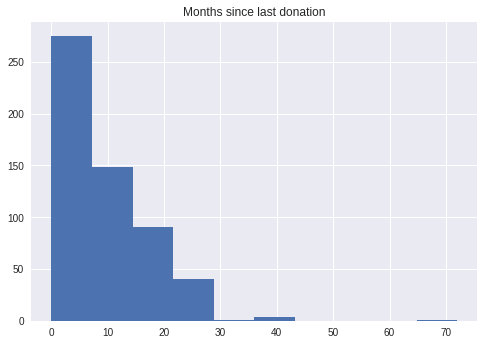

In [194]:
X_train['months_since_last_donation'].hist();
plt.title('Months since last donation');

### From this histogram it looks like there are a lot of frequent donations.
### In 2005 there was a bird flu epidemic in Asia.  Those who carried the virus, but did not die, also carried the immunizing agent in their blood.  This is probably why there were lots of blood donations.  If so, the blood donations started just 2 years earlier.
### More and more people must have donated blood over those two years.  Since people can give blood every 56 days (say 2 months), many of those who gave blood in March, must have given blood 2 months ago.  Let's see if this is true.

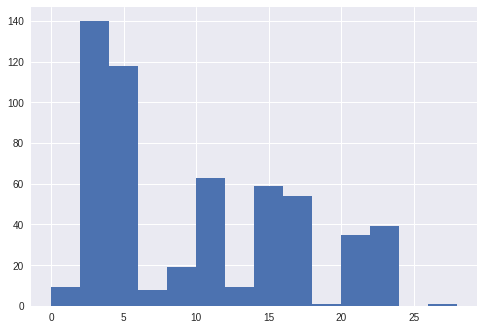

In [195]:
X_train['months_since_last_donation'].hist(bins = range(0, 30, 2));

### Looks like there is a pattern.  But, this pattern is already in the data, so there is no additional information here.

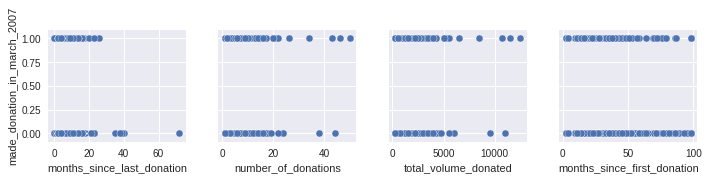

In [196]:
df2 = X_train
df2 = df2.join(pd.DataFrame(y_train, columns = ['made_donation_in_march_2007']))
df2.head()
sns.pairplot(data = df2,
             y_vars = 'made_donation_in_march_2007',
             x_vars = df2.drop(['made_donation_in_march_2007'], axis = 1).columns);

### Can't think of any new features to add.  How about removing features.  Looks like months since first donation is not a good discriminator. Remove it.

In [0]:
X_train = X_train.drop('months_since_first_donation', axis = 1)

In [198]:
pipeline = make_pipeline(MinMaxScaler(),
                         SelectKBest(f_classif),
                         LogisticRegression())
pipeline

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f8c255f3378>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [203]:
param_grid = {
    'selectkbest__k': [1, 2, 3],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
}

gs = GridSearchCV(pipeline, param_grid = param_grid, cv = 5,
                 scoring = 'recall', verbose = 0)
gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.pa

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f8c255f3378>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'selectkbest__k': [1, 2, 3], 'logisticregression__class_weight': [None, 'balanced'], 'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [204]:
print('Cross-validation Best Score:', gs.best_score_)
print('Best estimator', gs.best_estimator_)

Cross-validation Best Score: 0.7781942095667586
Best estimator Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=1, score_func=<function f_classif at 0x7f8c255f3378>)), ('logisticregression', LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])


### Still no luck.  Let's try with different transformations (RobustScaler)

### Part2: Different transformations

In [207]:
pipeline = make_pipeline(RobustScaler(),
                         SelectKBest(f_classif),
                         LogisticRegression())
pipeline

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f8c255f3378>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_int...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [208]:
param_grid = {
    'selectkbest__k': [1, 2, 3],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
}

gs = GridSearchCV(pipeline, param_grid = param_grid, cv = 5,
                 scoring = 'recall', verbose = 0)
gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f8c255f3378>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_int...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'selectkbest__k': [1, 2, 3], 'logisticregression__class_weight': [None, 'balanced'], 'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [209]:
print('Cross-validation Best Score:', gs.best_score_)
print('Best estimator', gs.best_estimator_)

Cross-validation Best Score: 0.7781942095667586
Best estimator Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=1, score_func=<function f_classif at 0x7f8c255f3378>)), ('logisticregression', LogisticRegression(C=0.0001, class_weight='balanced', dual=False,...penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])


### Try with the full X_train (no dropping columns), and with RobustScaler

In [0]:
X_train = df2.drop(['made_donation_in_march_2007'], axis = 1)

In [212]:
pipeline = make_pipeline(RobustScaler(),
                         SelectKBest(f_classif),
                         LogisticRegression())
pipeline
param_grid = {
    'selectkbest__k': [1, 2, 3],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
}

gs = GridSearchCV(pipeline, param_grid = param_grid, cv = 5,
                 scoring = 'recall', verbose = 0)
gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f8c255f3378>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_int...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'selectkbest__k': [1, 2, 3], 'logisticregression__class_weight': [None, 'balanced'], 'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [213]:
print('Cross-validation Best Score:', gs.best_score_)
print('Best estimator', gs.best_estimator_)

Cross-validation Best Score: 0.7781942095667586
Best estimator Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('selectkbest', SelectKBest(k=1, score_func=<function f_classif at 0x7f8c255f3378>)), ('logisticregression', LogisticRegression(C=0.0001, class_weight='balanced', dual=False,...penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])


### Part3: 

In [216]:
print('Selected features:\n')
X_train.columns

Selected features:



Index(['months_since_last_donation', 'number_of_donations',
       'total_volume_donated', 'months_since_first_donation'],
      dtype='object')

In [218]:
y_pred = gs.predict(X_test)
print('Final test score:', recall_score(y_test, y_pred))

Final test score: 0.7659574468085106


### Part 4: Predict F1 score and calculate False Positive rate

In [220]:
print('f1 score:', f1_score(y_test, y_pred))

f1 score: 0.48


In [226]:
# For the binary prediction, we can extract values
# from the confusion matrix as shown.
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('False positive rate:', fp / (fp + tn))

False positive rate: 0.4785714285714286
